In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### get the hourly ED occupancy

In [2]:
hourly = pd.read_pickle('./../../data/interim/D3_dailyTS/EDhourly_occupancy.pkl')

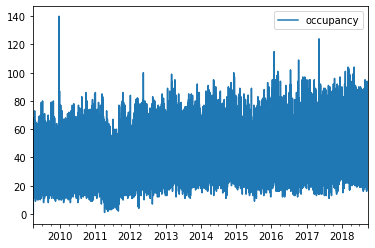

In [3]:
hourly.plot()

#### get timeindex to iterate over

#### save data out

EDinstance.to_pickle('./../../data/interim/D3_dailyTS/EDhourly_occupancy.pkl')

#### group hourly data to daily data

At present using a mean of the occupancy for each day. We could consider using a max or 0.75 quantile?

In [4]:
hourly['dt_date'] = hourly.index

In [5]:
pd.datetime(2018,1,1,11).replace(hour=0)

datetime.datetime(2018, 1, 1, 0, 0)

In [6]:
hourly['dt_date'] = hourly.dt_date.apply(lambda x : x.replace(hour=0))

In [7]:
hourly.tail()

,occupancy,dt_date
2018-09-29 20:00:00,46,2018-09-29
2018-09-29 21:00:00,58,2018-09-29
2018-09-29 22:00:00,54,2018-09-29
2018-09-29 23:00:00,55,2018-09-29
2018-09-30 00:00:00,57,2018-09-30


In [8]:
daily = pd.DataFrame(hourly.groupby(['dt_date']).mean()['occupancy'])

In [9]:
daily.head(2)

,occupancy
dt_date,
2009-04-01,28.458333
2009-04-02,36.875000


# flag outlier function 

In [10]:
def make_callender_columns(df,column,prefix):
    """
    takes a datetime column and creates multiple new columns with: hour of day, day of week, month of year.
    Input
    df, df: dataframe
    column, str: name of datetime column to work from
    prefix, str: give prefix for new column names

    Output
    df, df: new df with additional columns with numerical indicators for callender vars.
    """
    dft = df # needed for cases which do not have missing datetime values

    if df[column].isnull().sum() != 0:
        warnings.warn('Some datetimes in your column are missing.')
        dft = df[df[column].notnull()] # create ref of df without rows that contain missing vals


    df[prefix + '_hour'] = dft[column].dt.hour.astype(int)
    df[prefix + '_dayofweek'] = dft[column].dt.dayofweek.astype(int)
    df[prefix + '_day'] = dft[column].dt.day.astype(int)
    df[prefix + '_month'] = dft[column].dt.month.astype(int)
    df[prefix + '_week'] = dft[column].dt.week.astype(int)
    df[prefix + '_dayofweek_name'] = dft[column].dt.weekday_name.astype(str)
    df[prefix + '_year'] = dft[column].dt.year.astype(int)
    df[prefix + '_date'] = dft[column].dt.date.astype(object)
    df[prefix + '_flag_wkend'] = (df[prefix + '_dayofweek'] > 5).astype(int)
    return(df)

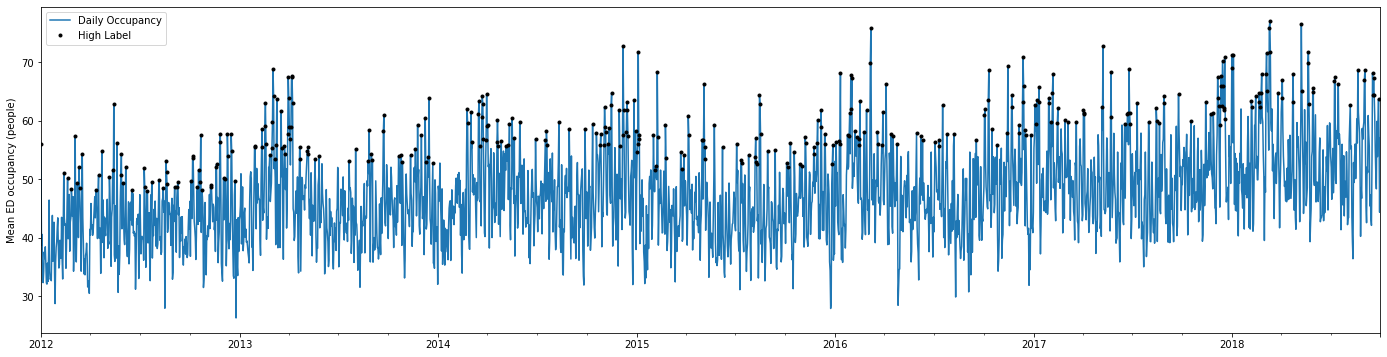

In [11]:
# from flosp.basic_tools import make_callender_columns
import matplotlib.pyplot as plt

def create_column_with_busy_days_flag(df,col_name, quantile, plot=False, plot_years = None ):
    """
    Function to create new column with 0,1 flag for prediction.
    Calculates the quantile value for each year and sets 1's to be all values exceeding that value.
    
    Input
    -----
    df, pandas dataframe, index column as date
    col_name, string, name of column which contains the measure
    quantile, float, quantile above which days will be flagged as being crowded. e.g. 0.8
    plot, boolean, (optional) if true return plot of the flagged points.
    plot_years, list of int, (optional) of years to include in plot.
    
    Return
    ------
    df, pandas dataframe, with flag_target column containing 0,1s.
    """
    #### get index into columns and make columns for grouping
    df['date'] = df.index
    df['date'] = pd.to_datetime(df['date']) # make date into dateitme
    df = make_callender_columns(df,'date','d') # get year column
    
    #### get quantile data & merge back into original df
    year_describe = pd.DataFrame(df.groupby(['d_year']).quantile(quantile)[col_name]).rename(columns={col_name:'quantile'})
    df_withyearly = df.merge(year_describe,left_on='d_year',right_index=True)
    
    #### make flag for those above quantile for each year
    df_withyearly['flag_target'] = df_withyearly.apply(lambda x : x[col_name] > x['quantile'], axis=1).astype(int)
    
    #### optional plotting
    if plot == True:
        if plot_years == None:
            dff = df_withyearly
        else:
            dff = df_withyearly.query('d_year in ' + str(plot_years))
            
        target_col = col_name
        fig, ax = plt.subplots()
        dff[target_col].plot(ax=ax,figsize=(24,6))
        dff[dff.flag_target == 1][target_col].plot(ax=ax,style='.k')
        ax.set_ylabel('Mean ED occupancy (people)')
        ax.set_xlabel('')
        ax.legend(['Daily Occupancy','High Label'],frameon=True,loc='upper left')
    
    return(df_withyearly[[col_name,'flag_target']])

df = create_column_with_busy_days_flag(daily,'occupancy',0.85,True,[2012,2013,2014,2015,2016,2017,2018])

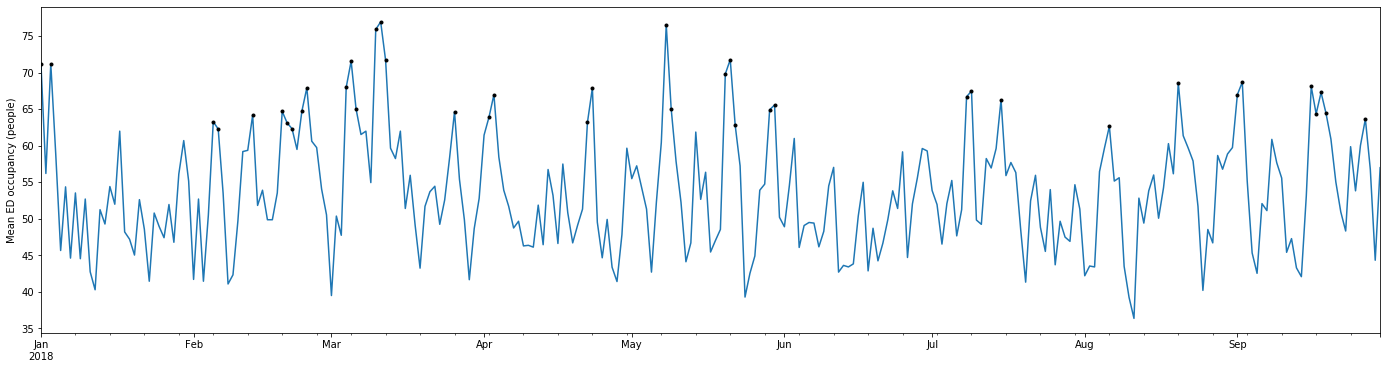

In [16]:
# from flosp.basic_tools import make_callender_columns
import matplotlib.pyplot as plt

def create_column_with_busy_days_flag(df,col_name, quantile, plot=False, plot_years = None ):
    """
    Function to create new column with 0,1 flag for prediction.
    Calculates the quantile value for each year and sets 1's to be all values exceeding that value.
    
    Input
    -----
    df, pandas dataframe, index column as date
    col_name, string, name of column which contains the measure
    quantile, float, quantile above which days will be flagged as being crowded. e.g. 0.8
    plot, boolean, (optional) if true return plot of the flagged points.
    plot_years, list of int, (optional) of years to include in plot.
    
    Return
    ------
    df, pandas dataframe, with flag_target column containing 0,1s.
    """
    #### get index into columns and make columns for grouping
    df['date'] = df.index
    df['date'] = pd.to_datetime(df['date']) # make date into dateitme
    df = make_callender_columns(df,'date','d') # get year column
    
    #### get quantile data & merge back into original df
    year_describe = pd.DataFrame(df.groupby(['d_year']).quantile(quantile)[col_name]).rename(columns={col_name:'quantile'})
    df_withyearly = df.merge(year_describe,left_on='d_year',right_index=True)
    
    #### make flag for those above quantile for each year
    df_withyearly['flag_target'] = df_withyearly.apply(lambda x : x[col_name] > x['quantile'], axis=1).astype(int)
    
    #### optional plotting
    if plot == True:
        if plot_years == None:
            dff = df_withyearly
        else:
            dff = df_withyearly.query('d_year in ' + str(plot_years))
            
        target_col = col_name
        fig, ax = plt.subplots()
        dff[target_col].plot(ax=ax,figsize=(24,6))
        dff[dff.flag_target == 1][target_col].plot(ax=ax,style='.k')
        ax.set_ylabel('Mean ED occupancy (people)')
        ax.set_xlabel('')
    
    return(df_withyearly[[col_name,'flag_target']])

df = create_column_with_busy_days_flag(daily,'occupancy',0.85,True,[2018])

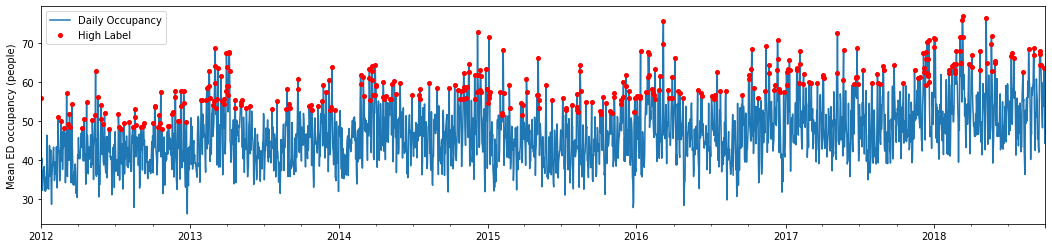

In [18]:
# from flosp.basic_tools import make_callender_columns
import matplotlib.pyplot as plt

def create_column_with_busy_days_flag(df,col_name, quantile, plot=False, plot_years = None ):
    """
    Function to create new column with 0,1 flag for prediction.
    Calculates the quantile value for each year and sets 1's to be all values exceeding that value.
    
    Input
    -----
    df, pandas dataframe, index column as date
    col_name, string, name of column which contains the measure
    quantile, float, quantile above which days will be flagged as being crowded. e.g. 0.8
    plot, boolean, (optional) if true return plot of the flagged points.
    plot_years, list of int, (optional) of years to include in plot.
    
    Return
    ------
    df, pandas dataframe, with flag_target column containing 0,1s.
    """
    #### get index into columns and make columns for grouping
    df['date'] = df.index
    df['date'] = pd.to_datetime(df['date']) # make date into dateitme
    df = make_callender_columns(df,'date','d') # get year column
    
    #### get quantile data & merge back into original df
    year_describe = pd.DataFrame(df.groupby(['d_year']).quantile(quantile)[col_name]).rename(columns={col_name:'quantile'})
    df_withyearly = df.merge(year_describe,left_on='d_year',right_index=True)
    
    #### make flag for those above quantile for each year
    df_withyearly['flag_target'] = df_withyearly.apply(lambda x : x[col_name] > x['quantile'], axis=1).astype(int)
    
    #### optional plotting
    if plot == True:
        if plot_years == None:
            dff = df_withyearly
        else:
            dff = df_withyearly.query('d_year in ' + str(plot_years))
            
        target_col = col_name
        fig, ax = plt.subplots()
        dff[target_col].plot(ax=ax,figsize=(18,4))
        dff[dff.flag_target == 1][target_col].plot(ax=ax,style='.r',ms=8)
        ax.set_ylabel('Mean ED occupancy (people)')
        ax.set_xlabel('')
        ax.legend(['Daily Occupancy','High Label'],frameon=True,loc='upper left')
    
    return(df_withyearly[[col_name,'flag_target']])

df = create_column_with_busy_days_flag(daily,'occupancy',0.85,True,[2012,2013,2014,2015,2016,2017,2018])

In [19]:
df.head()

,occupancy,flag_target
dt_date,,
2009-04-01,28.458333,0
2009-04-02,36.875000,0
2009-04-03,41.458333,0
2009-04-04,36.541667,0
2009-04-05,41.625000,0


In [20]:
df.rename(columns={'occupancy':'EDMeanOcc'},inplace=True)

In [22]:
df.to_pickle('./../../data/interim/D3_dailyTS/EDdaily_occupancy_class15.pkl')

In [24]:
break

SyntaxError: 'break' outside loop (cell_name, line 4)

# Dev 

In [6]:
break

SyntaxError: 'break' outside loop (<ipython-input-6-6aaf1f276005>, line 1)

In [27]:
df['datetime'] = df.index

In [30]:
df = make_callender_columns(df,'datetime','dt')

----------------------------------------
Making callender columns from:  datetime


In [33]:
df = df.query('dt_year >= 2012')

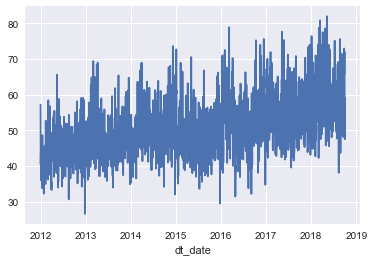

In [36]:
df.groupby(['dt_date']).mean()['EDocc'].plot()

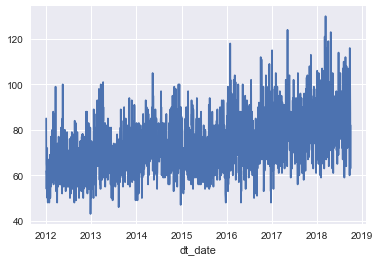

In [37]:
df.groupby(['dt_date']).max()['EDocc'].plot()

In [38]:
df.groupby(['dt_date']).mean()['EDocc'].describe()

count    2465.000000
mean       50.926640
std         8.143732
min        26.541667
25%        45.291667
50%        50.166667
75%        55.791667
max        82.000000
Name: EDocc, dtype: float64

In [39]:
df.groupby(['dt_date']).max()['EDocc'].describe()

count    2465.000000
mean       73.701014
std        11.719750
min        43.000000
25%        65.000000
50%        73.000000
75%        81.000000
max       130.000000
Name: EDocc, dtype: float64

In [48]:
occD = pd.DataFrame(df.groupby(['dt_date']).mean()['EDocc'])

In [49]:
occD.head()

,EDocc
dt_date,
2012-01-01,57.166667
2012-01-02,40.458333
2012-01-03,43.625000
2012-01-04,36.291667
2012-01-05,36.000000


In [50]:
occD['date'] = occD.index

In [51]:
occD.head(2)

,EDocc,date
dt_date,,
2012-01-01,57.166667,2012-01-01
2012-01-02,40.458333,2012-01-02


In [54]:
occD['date'] = pd.to_datetime(occD['date'])

occD = make_callender_columns(occD,'date','d')

In [56]:
occD.head()

,EDocc,date,d_hour,d_dayofweek,d_day,d_month,d_week,d_dayofweek_name,d_year,d_date,d_flag_wkend
dt_date,,,,,,,,,,,
2012-01-01,57.166667,2012-01-01,0,6,1,1,52,Sunday,2012,2012-01-01,1
2012-01-02,40.458333,2012-01-02,0,0,2,1,1,Monday,2012,2012-01-02,0
2012-01-03,43.625000,2012-01-03,0,1,3,1,1,Tuesday,2012,2012-01-03,0
2012-01-04,36.291667,2012-01-04,0,2,4,1,1,Wednesday,2012,2012-01-04,0
2012-01-05,36.000000,2012-01-05,0,3,5,1,1,Thursday,2012,2012-01-05,0


In [78]:
year_describe = pd.DataFrame(occD.groupby(['d_year']).quantile(0.85)['EDocc']).rename(columns={'EDocc':'quantile'})
year_describe

,quantile
d_year,
2012,50.760417
2013,55.116667
2014,58.416667
2015,55.475000
2016,59.177083
2017,63.341667
2018,68.425000


In [79]:
occD_yearly = occD.merge(year_describe,left_on='d_year',right_index=True)
occD_yearly.head()

,EDocc,date,d_hour,d_dayofweek,d_day,d_month,d_week,d_dayofweek_name,d_year,d_date,d_flag_wkend,quantile
dt_date,,,,,,,,,,,,
2012-01-01,57.166667,2012-01-01,0,6,1,1,52,Sunday,2012,2012-01-01,1,50.760417
2012-01-02,40.458333,2012-01-02,0,0,2,1,1,Monday,2012,2012-01-02,0,50.760417
2012-01-03,43.625000,2012-01-03,0,1,3,1,1,Tuesday,2012,2012-01-03,0,50.760417
2012-01-04,36.291667,2012-01-04,0,2,4,1,1,Wednesday,2012,2012-01-04,0,50.760417
2012-01-05,36.000000,2012-01-05,0,3,5,1,1,Thursday,2012,2012-01-05,0,50.760417


In [80]:
occD_yearly['flag'] = occD_yearly.apply(lambda x : x.EDocc > x['quantile'], axis=1).astype(int)

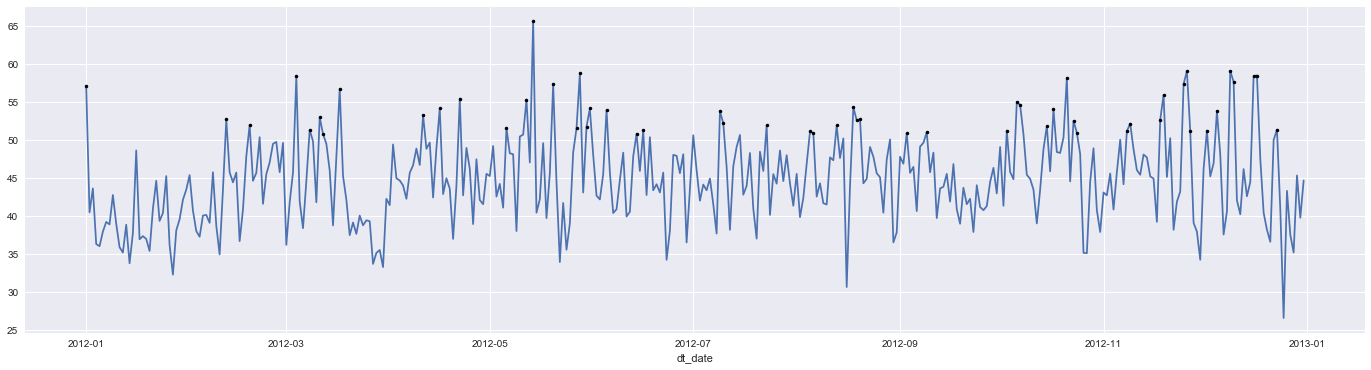

In [93]:
dff = occD_yearly.query('d_year == 2012')

target_col = 'EDocc'

fig, ax = plt.subplots()
dff[target_col].plot(ax=ax,figsize=(24,6))

dff[dff.flag == 1][target_col].plot(ax=ax,style='.k')